### Importing Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import cv2

### Setting Random Seed for Reproducibility

In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Calling set_seed
set_seed(42)

### Device Configuration and Dataset Setup

In [3]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset paths
DATA_DIR = '/kaggle/input/kermany2018/OCT2017 ' 

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Define class names
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = len(classes)

Using device: cpu


### Preprocessing Function: CLAHE

In [4]:
# Preprocessing function for CLAHE
def apply_clahe(img):
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # RGB image
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:  # Already grayscale
        img_gray = img_np
        
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray.astype(np.uint8))
    
    # Convert back to PIL image
    return Image.fromarray(img_clahe)

### Preprocessing Function: Background Noise Removal

In [5]:
# Preprocessing function for removing background noise
def remove_background_noise(img):
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # RGB image
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else: 
        img_gray = img_np
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Threshold to remove background noise
    _, thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_TOZERO)
    
    # Convert back to PIL image
    return Image.fromarray(thresh)

### Preprocessing Function: Edge Enhancement

In [6]:
# Preprocessing function for edge enhancement
def enhance_edges(img):
    """Enhance edges using unsharp masking"""
    img_np = np.array(img)
    if len(img_np.shape) == 3:  # RGB image
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:  # Already grayscale
        img_gray = img_np
    
    # Apply unsharp masking
    gaussian = cv2.GaussianBlur(img_gray, (0, 0), 3.0)
    unsharp_image = cv2.addWeighted(img_gray, 1.5, gaussian, -0.5, 0)
    
    # Convert back to PIL image
    return Image.fromarray(unsharp_image)

### Dataset Class: OCTDataset with Preprocessing

In [7]:
# Dataset class with preprocessing
class OCTDataset(Dataset):
    def __init__(self, root_dir, transform=None, preprocess=True):
        self.root_dir = root_dir
        self.transform = transform
        self.preprocess = preprocess
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
        
        # Load all image paths and labels
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory {class_dir} not found!")
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        # Verify dataset is not empty
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {root_dir}. Please check the directory path.")
    
    def preprocess_image(self, image):
        # Convert to grayscale
        if image.mode != 'L':
            image = image.convert('L')
        
        # Remove background noise
        image = remove_background_noise(image)
        
        # Apply CLAHE for contrast enhancement
        image = apply_clahe(image)
        
        # Enhance edges
        image = enhance_edges(image)
        
        return image
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply preprocessing
        if self.preprocess:
            image = self.preprocess_image(image)
            # Convert back to RGB
            if image.mode == 'L':
                image = Image.merge('RGB', (image, image, image))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### Data Transformations for Training and Evaluation

In [8]:
# Create data transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),          
    transforms.Resize((224, 224)),                         
    transforms.RandomHorizontalFlip(),                     
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                                 
    transforms.Normalize(mean=[0.5], std=[0.5])            
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),     
    transforms.Resize((224, 224)),                   
    transforms.ToTensor(),                           
    transforms.Normalize(mean=[0.5], std=[0.5])      
])

### Creating Dataset Instances with Transformations

In [9]:
# Create dataset instances
train_dataset = OCTDataset(TRAIN_DIR, transform=train_transform, preprocess=True)
val_dataset = OCTDataset(VAL_DIR, transform=val_test_transform, preprocess=True)
test_dataset = OCTDataset(TEST_DIR, transform=val_test_transform, preprocess=True)

### Class Distribution Analysis and Visualization

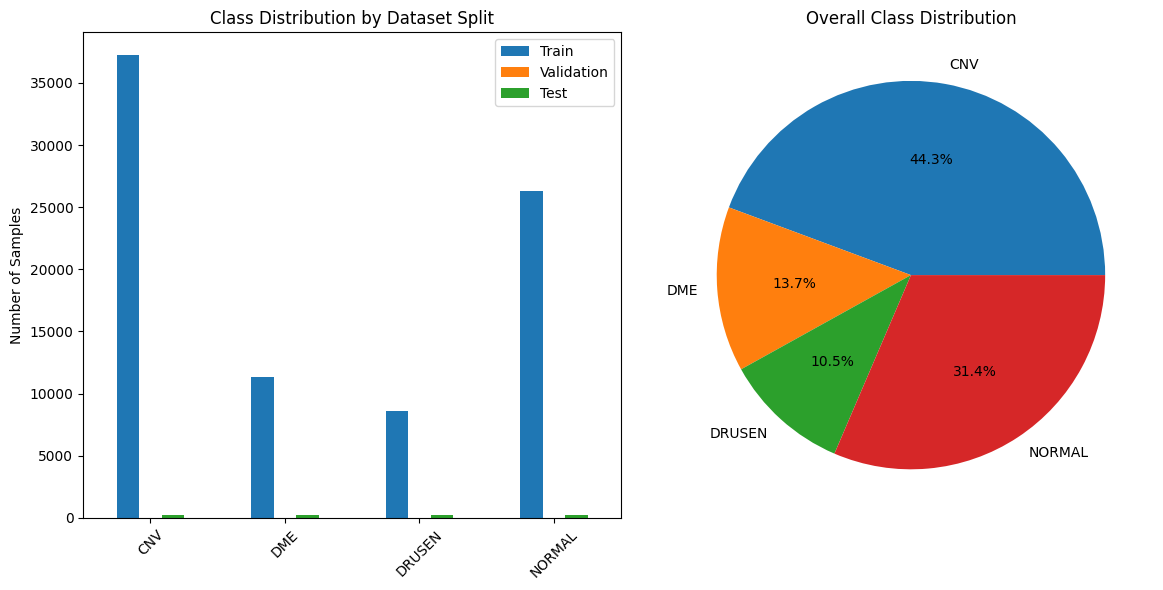

Class Distribution:
        Train  Validation  Test  Total  Percentage
CNV     37205           8   242  37455       44.33
DME     11348           8   242  11598       13.73
DRUSEN   8616           8   242   8866       10.49
NORMAL  26315           8   242  26565       31.44


In [10]:
# Class distribution analysis
def analyze_class_distribution():
    # Function to count classes
    def count_class_samples(dataset_dir):
        counts = {class_name: 0 for class_name in classes}
        for class_name in classes:
            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.exists(class_dir):
                counts[class_name] = len([f for f in os.listdir(class_dir) 
                                         if f.endswith('.jpeg')])
        return counts
    
    # Count samples in each split
    train_counts = count_class_samples(TRAIN_DIR)
    val_counts = count_class_samples(VAL_DIR)
    test_counts = count_class_samples(TEST_DIR)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Train': train_counts,
        'Validation': val_counts,
        'Test': test_counts
    })
    
    # Add total column
    df['Total'] = df.sum(axis=1)
    
    # Add percentage columns
    total_samples = df['Total'].sum()
    df['Percentage'] = (df['Total'] / total_samples * 100).round(2)
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    
    # Class distribution
    plt.subplot(1, 2, 1)
    df[['Train', 'Validation', 'Test']].plot(kind='bar', ax=plt.gca())
    plt.title('Class Distribution by Dataset Split')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Percentage distribution
    plt.subplot(1, 2, 2)
    plt.pie(df['Total'], labels=df.index, autopct='%1.1f%%')
    plt.title('Overall Class Distribution')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png')
    plt.show()
    
    # Print table
    print("Class Distribution:")

    print(df)
    
    return df

# Analyze class distribution
class_dist = analyze_class_distribution()

### Calculating Class Weights for Imbalanced Data

In [11]:
def calculate_class_weights(class_distribution_df):
    # Get sample counts
    class_counts = class_distribution_df['Total'].to_dict()
    total_samples = sum(class_counts.values())
    
    # Calculate weights: n_samples / (n_classes * n_samples_for_class)
    num_classes = len(class_counts)
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
    
    # Convert to tensor for the loss function
    weights_tensor = torch.FloatTensor([class_weights[cls] for cls in classes]).to(device)
    
    return class_weights, weights_tensor

# Calculate class weights
class_weights_dict, weights_tensor = calculate_class_weights(class_dist)

### Creating Weighted Sampler for Class Imbalance

In [12]:
def create_weighted_sampler(dataset, class_weights):
    if isinstance(dataset, torch.utils.data.Subset):
        # For datasets created with random_split
        if isinstance(dataset.dataset, torch.utils.data.ConcatDataset):
            # Handle case when dataset.dataset is a ConcatDataset
            labels = []
            for idx in dataset.indices:
                dataset_idx = 0
                sample_idx = idx
                for d in dataset.dataset.datasets:
                    if sample_idx < len(d):
                        break
                    sample_idx -= len(d)
                    dataset_idx += 1
                if dataset_idx < len(dataset.dataset.datasets):
                    d = dataset.dataset.datasets[dataset_idx]
                    labels.append(d.labels[sample_idx])
        else:
            # Regular Subset
            labels = [dataset.dataset.labels[i] for i in dataset.indices]
    else:
        # For original datasets
        if isinstance(dataset, torch.utils.data.ConcatDataset):
            # Handle concatenated datasets
            labels = []
            for d in dataset.datasets:
                labels.extend(d.labels)
        else:
            # Regular Dataset
            labels = dataset.labels
        
    # Assign weights to each sample based on its class
    weights = [class_weights[classes[label]] for label in labels]
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

### Creating DataLoaders with Weighted Sampler

In [13]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, class_weights, batch_size=32):
    # Create weighted sampler for training data
    train_sampler = create_weighted_sampler(train_dataset, class_weights)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler,  # Using weighted sampler
        num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4
    )
    
    return train_loader, val_loader, test_loader

### Creating DataLoaders for Training, Validation, and Testing

In [14]:
# Create data loaders
batch_size = 32
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, class_weights_dict, batch_size
)

### Printing Dataset Sizes

In [ ]:
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# CNN Model for OCT Image Classification

In [ ]:
# CNN model
class OCT_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(OCT_CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        
        # Fifth convolutional block
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # Apply convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Apply fully connected layers
        x = self.fc(x)
        
        return x

### Initializing the OCT_CNN Model

In [ ]:
# Initialize the model
model = OCT_CNN(num_classes=num_classes).to(device)
print(model)

### Displaying Model Summary

In [ ]:
from torchinfo import summary
summary(model, input_size=(1, 1, 224, 224), verbose=2)

### Counting Trainable Parameters and Defining Optimizer

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6
)

### Visualizing Preprocessing Steps on OCT Images

In [ ]:
def visualize_preprocessing(dataset_dir):
    classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, 4, figsize=(20, num_classes*5))
    
    for i, class_name in enumerate(classes):
        # Get class directory
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Class directory {class_dir} not found!")
            continue
            
        # Get a random image from this class
        img_files = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]
        if not img_files:
            print(f"Warning: No images found in {class_dir}")
            continue
            
        img_file = np.random.choice(img_files)
        img_path = os.path.join(class_dir, img_file)
        
        # Original image
        img_orig = Image.open(img_path).convert('L')
        axes[i, 0].imshow(img_orig, cmap='gray')
        axes[i, 0].set_title(f"Original - {class_name}")
        axes[i, 0].axis('off')
        
        # After noise removal
        img_noise_removed = remove_background_noise(img_orig)
        axes[i, 1].imshow(img_noise_removed, cmap='gray')
        axes[i, 1].set_title("After Noise Removal")
        axes[i, 1].axis('off')
        
        # After CLAHE
        img_clahe = apply_clahe(img_noise_removed)
        axes[i, 2].imshow(img_clahe, cmap='gray')
        axes[i, 2].set_title("After CLAHE")
        axes[i, 2].axis('off')
        
        # After edge enhancement
        img_edges = enhance_edges(img_clahe)
        axes[i, 3].imshow(img_edges, cmap='gray')
        axes[i, 3].set_title("After Edge Enhancement")
        axes[i, 3].axis('off')
    
    plt.show()

# Visualizing preprocessing
train_dir = os.path.join('/kaggle/input/kermany2018/OCT2017 /train')
visualize_preprocessing(train_dir)

### Model Evaluation Function

In [ ]:
# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

### Training Function with Early Stopping

In [ ]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=20, patience=7):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    training_stats = []
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_oct_model.pth')
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
        
        # Save training stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': epoch_loss,
            'train_acc': epoch_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'lr': optimizer.param_groups[0]['lr']
        })
    
    # Load best model
    model.load_state_dict(torch.load('best_oct_model.pth'))
    return model, training_stats

# Train the model
model, training_stats = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    num_epochs=20, patience=7
)

### Function to Visualize Training Progress

In [ ]:
# Function to visualize training progress
def plot_training_stats(training_stats):
    stats_df = pd.DataFrame(training_stats)
    
    # Create a figure with 3 subplots
    plt.figure(figsize=(18, 6))
    
    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(stats_df['epoch'], stats_df['train_loss'], label='Train')
    plt.plot(stats_df['epoch'], stats_df['val_loss'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(stats_df['epoch'], stats_df['train_acc'], label='Train')
    plt.plot(stats_df['epoch'], stats_df['val_acc'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Plot training statistics
plot_training_stats(training_stats)

### Function to Test the Model and Generate Classification Repor

In [ ]:
# Function to test model and generate classification report
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test accuracy
    test_acc = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    plt.close()
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("\nClassification Report:")
    print(report)
    
    return cm, report, test_acc

### Testing the model

In [ ]:
# Test the model
cm, report, test_acc = test_model(model, test_loader)